# Qaintellect implementation of Variational Quantum Thermalizer Algorithm

In this example, we implement the optimization of a circuit based on the VQT algorithm using the Quantum
Hamiltonian-Based Models (QHBM) framework

Reference:
- G Verdon, J Marks, S Nanda, S Leichenauer, and J Hidary1: "Quantum Hamiltonian-Based Models &
the Variational Quantum Thermalizer Algorithm", [arXiv:1910.02071](https://arxiv.org/pdf/1910.02071.pdf) (2019)

In [77]:
using Qaintessent
using Qaintellect
using LinearAlgebra
using Flux
import Pkg; Pkg.add("IterTools");Pkg.add("Plots"); Pkg.add("LaTeXStrings")
using IterTools: ncycle
using SparseArrays

  Resolving package versions...
No Changes to `/import/home/ga53vuw/.julia/environments/v1.5/Project.toml`
No Changes to `/import/home/ga53vuw/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
  Installed Plots ─ v1.15.2
Updating `/import/home/ga53vuw/.julia/environments/v1.5/Project.toml`
  [91a5bcdd] + Plots v1.15.2
Updating `/import/home/ga53vuw/.julia/environments/v1.5/Manifest.toml`
  [91a5bcdd] ↑ Plots v1.10.6 ⇒ v1.15.2
  Resolving package versions...
No Changes to `/import/home/ga53vuw/.julia/environments/v1.5/Project.toml`
No Changes to `/import/home/ga53vuw/.julia/environments/v1.5/Manifest.toml`


In [78]:
# visualization
using Plots
using LaTeXStrings

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/home/ga53vuw/.julia/packages/Plots/iYDwd/src/backends/hdf5.jl", 162, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fabd9ffd2af, Ptr{Nothing} @0x00007fabda08a21c, Ptr{Nothing} @0x00007fabda08a765, Ptr{Nothing} @0x00007fabda08a3cf, Ptr{Nothing} @0x00007fabda08add3, Ptr{Nothing} @0x00007fabda08c037, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x00007fabda0a92f9, Ptr{Nothing} @0x00007fabda0a9a67, Ptr{Nothing} @0x00007fabda0a8e5a, Ptr{Nothing} @0x00007fabda0a8df9, Ptr{Nothing} @0x00007fabda07b825, Ptr{Nothing} @0x00007fabda0aa8d1, Ptr{Nothing} @0x00007fabcbe6e74d, Ptr{Nothing} @0x00007fab9f9e16be, Ptr{Nothing} @0x00007fabda070d57, Ptr{Nothing} @0x00007fabda08a785, Ptr{Nothing} @0x00007fabda08a3cf, Ptr{Nothing} @0x00007fabda08add3, 

## Definition of the VQT Algorithm

In this problem, we are given a target Hamiltonian $\hat{H}$ and a target inverse temperature $\beta$. We then try to reconstruct an approximation to the thermal state:
\begin{equation}
\sigma_{\beta}=\frac{1}{Z_{\beta}} e^{-\beta \hat{H}}
\end{equation}

The QHBM framework characterizes a quantum state via a parameterized latent model (density matrix) $\hat{\rho}(\theta)$ and a unitary $U(\phi)$. These are combined to form the visible model $\hat{\rho}_{\theta\phi} = U_{\phi}\hat{\rho}_{\theta}U^{\dagger}_{\phi}$

We use the following loss function:
\begin{equation}
L_{VQT}(\theta, \phi) = \beta \textrm{tr}(\hat{\rho}_{\theta\phi}\hat{H}) - S(\hat{\rho}_{\theta\phi})
\end{equation}

The variational circuit is based on a 2D Heisenberg model:
\begin{equation}
H_{HEIS} = \sum_{<ij>_{h}}{J_hS_iS_j} + \sum_{<ij>_{v}}{J_vS_iS_j},
\end{equation}
where h (v) denote the horizontal (vertical) nearest-neighbour pairs.

In [93]:
# number of qubits
n_x = 2
n_y = 2
N = n_x * n_y
layers = 3

J_x = 1.0
J_y = 0.6
β = 2.6
S = sparse_matrix(X) + sparse_matrix(Y) + sparse_matrix(Z)
SS_x = J_x.*kron(S, S)
SS_y = J_y.*kron(S, S)

H = sparse(zeros((2^N, 2^N)))
for k in 1:n_y
    for j in 1:n_x-1
        pos = j+(k-1)*n_x
        H += Qaintessent.distribute_to_wires(SS_x, [pos, pos+1], N, 2)
    end
end

for k in 1:n_y-1
    for j in 1:n_x
        pos = j+(k-1)*n_x
        H += Qaintessent.distribute_to_wires(SS_y, [pos, pos+n_x], N, 2)
    end
end

In [66]:
# create parametric circuit
function apply_layer(circuit::Circuit, n_x::Int, n_y)
    for i in 1:(n_x*n_y)
        ϕ = rand(Float64, 3)
        append!(circuit, circuit_gate(i, RxGate(ϕ[1])))
        append!(circuit, circuit_gate(i, RyGate(ϕ[2])))
        append!(circuit, circuit_gate(i, RzGate(ϕ[3])))
    end
                
    for k in 1:n_y
        for j in 1:n_x-1
            ϕ = rand(Float64, 3)
            pos = j+(k-1)*n_x
            append!(circuit, circuit_gate((pos, pos+1), EntanglementXXGate(ϕ[1])))
            append!(circuit, circuit_gate((pos, pos+1), EntanglementYYGate(ϕ[2])))
            append!(circuit, circuit_gate((pos, pos+1), EntanglementZZGate(ϕ[3])))
        end
    end
    
    for k in 1:n_y-1
        for j in 1:n_x
            ϕ = rand(Float64, 3)
            pos = (k-1)*n_x+j
            append!(circuit, circuit_gate((pos, pos+n_x), EntanglementXXGate(ϕ[1])))
            append!(circuit, circuit_gate((pos, pos+n_x), EntanglementYYGate(ϕ[2])))
            append!(circuit, circuit_gate((pos, pos+n_x), EntanglementZZGate(ϕ[3])))
        end
    end
end

function generate_unitary(layers::Int, n_x::Int, n_y::Int)
    N = n_x * n_y
    c = Circuit{N}()
    for _ in 1:layers
        apply_layer(c, n_x, n_y)
    end
    c
end
circuit = generate_unitary(layers, n_x, n_y);

## Quantum formulation and construction of a quantum circuit

The variational circuit is based on a 2D Heisenberg model:
\begin{equation}
H_{HEIS} = \sum_{<ij>_{h}}{J_hS_iS_j} + \sum_{<ij>_{v}}{J_vS_iS_j},
\end{equation}
where h (v) denote the horizontal (vertical) nearest-neighbour pairs.

Based on the experiments described in Verdon et al., the 

The operator $B$ is chosen as
\begin{equation*}
B = \sum_{j=0}^{n-1} X_j
\end{equation*}
with $X_j$ the Pauli-$X$ matrix acting on qubit $j$.

The largest eigenvalue of $B$ is $n$ (since each $X_j$ in the sum contributes the value $1$). The eigenvector of $B$ corresponding to its largest eigenvalue is the uniform superposition state:
\begin{equation}
\lvert s \rangle = \lvert + \rangle^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{b=0}^{2^n - 1} \lvert b \rangle.
\end{equation}

In [4]:
# define uniform superposition state s
s_uni = fill(1/√(2^n) + 0.0im, 2^n);

According to the Schrödinger equation, a time step $\tau$ governed by a time-independent Hamiltonian $H$ is described by the unitary matrix $e^{-i \tau H}$. Even if $H$ slowly changes with time, $e^{-i \tau H(t)}$ is still a good approximation. Together with a splitting approximation for the matrix exponential, $e^{A + B} \approx e^A e^B$ for matrices $A$ and $B$ with small norm, we arrive at $e^{-i \tau H(t)} \approx e^{-i \tau (1 - \frac{t}{T}) B} \, e^{- i \tau \frac{t}{T} C}$ to describe a time step. This motivates the following Ansatz to find the maximizing eigenstate of $C$:
\begin{equation}
\lvert\psi_p(\gamma, \beta)\rangle = e^{-i \beta_p B} e^{-i \gamma_p C} \cdots e^{-i \beta_1 B} e^{-i \gamma_1 C} \lvert s \rangle
\end{equation}
with real parameters $\beta_1, \dots, \beta_p$ and $\gamma_1, \dots, \gamma_p$. The number of "layers" $p$ can be tuned depending on the application.

Note: we simulate the construction of $\lvert\psi_p(\gamma, \beta)\rangle$ here, but this would be performed on an actual quantum computer.

We can represent the unitary time step effected by $C_{\alpha}$ as $e^{-i \gamma C_{\alpha}} = e^{-i \gamma / 2} e^{i \gamma Z_j Z_k / 2}$. The global phase factor $e^{-i \gamma / 2}$ will drop out of the optimization, and the second term is the ZZ-"entanglement" gate.

In [5]:
function assemble_time_step_gates(p::Int, n::Int, edges::Vector{Tuple{Int,Int}})
    cgs = CircuitGate[]
    for _ in 1:p
        # C operator
        for e in edges
            # circuit gate uses 1-based indexing
            push!(cgs, circuit_gate(e[1] + 1, e[2] + 1, EntanglementZZGate(0.01*randn())))
        end
        # B operator
        for j in 1:n
           push!(cgs, circuit_gate(j, RxGate(0.01*randn())))
        end
    end
    return cgs
end

assemble_time_step_gates (generic function with 1 method)

In practice, one performs parameter optimization to maximize the expectation value
\begin{equation}
\langle\psi_p(\gamma, \beta)\rvert C \lvert\psi_p(\gamma, \beta)\rangle,
\end{equation}
such that $\lvert\psi_p(\gamma, \beta)\rangle$ approaches the optimal solution $\lvert b^{\text{opt}} \rangle$ (or a superposition in case there are several optimizers). The preparation of $\lvert\psi_p(\gamma, \beta)\rangle$ and evaluation of the expectation value is to be performed on a quantum computer, and the parameter optimization on a classical computer. A standard measurement of $\lvert\psi_p(\gamma, \beta)\rangle$ then results in $b^{\text{opt}}$ with high probability.

In [6]:
# create measurement operator representing C
Cmat = zeros(2^n, 2^n)
for edge in edges
    k1 = circuit_gate(edge[1] + 1, ZGate())
    k2 = circuit_gate(edge[2] + 1, ZGate())
    Cmat += 0.5*(I - sparse_matrix([k1, k2], n))
end
@show(diag(Cmat))
Cop = MeasurementOperator(Cmat, Tuple(1:n));

diag(Cmat) = Complex{Float64}[0.0 + 0.0im, 1.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 4.0 + 0.0im, 5.0 - 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 5.0 - 0.0im, 4.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]


In [7]:
# example
circ = Circuit{n}(assemble_time_step_gates(2, n, edges), [Cop])


    5 ————————————————————□—————□————[Rx]———————————————□—————□————[Rx]—
                          |     |                       |     |         
    4 ——————————————□———————————□————[Rx]—————————□———————————□————[Rx]—
                    |     |                       |     |               
    3 ————————□———————————□————[Rx]—————————□———————————□————[Rx]———————
              |     |                       |     |                     
    2 ——□—————□—————□——————————[Rx]———□—————□—————□——————————[Rx]———————
        |                             |                                 
    1 ——□——————————————————————[Rx]———□——————————————————————[Rx]———————


In [8]:
# example: apply circuit gates and compute expectation value
apply(s_uni, circ)

1-element Array{Float64,1}:
 2.499208652309536

## Perform optimization

In [9]:
# first attempt with p = 1

circ1 = Circuit{n}(assemble_time_step_gates(1, n, edges), [Cop])

# gather parameters from circuit
paras = Flux.params(circ1)

# there is not actually any input data for training
data = ncycle([()], 500)

# define optimizer
opt = Descent(0.5)

# define evaluation function
evalcb() = @show(apply(s_uni, circ1))

# perform minimization with the negated target function to achieve maximization
Flux.train!(() -> -apply(s_uni, circ1)[1], paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

apply(s_uni, circ1) = [2.5001403700650973]
apply(s_uni, circ1) = [3.9999999999999973]
apply(s_uni, circ1) = [4.0]


In [10]:
# corresponding optimized quantum wavefunction
ψ1 = apply(s_uni, circ1.moments);

It turns out that one layer is insufficient to unambiguously determine the optimal solution $b^{\text{opt}}$:

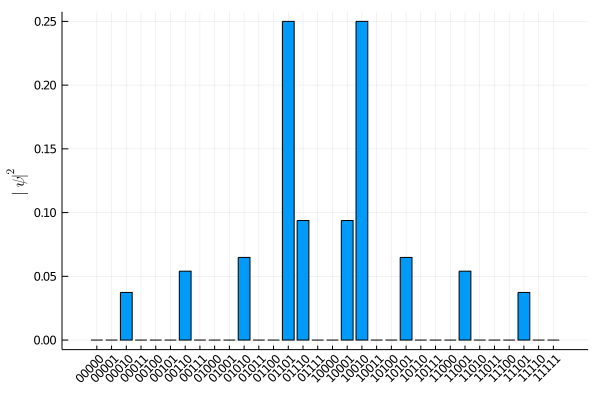

In [11]:
tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(ψ1), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false)

In [12]:
# increase number of layers to p = 2

circ2 = Circuit{n}(assemble_time_step_gates(2, n, edges), [Cop])

# gather parameters from circuit
paras = Flux.params(circ2)

# there is not actually any input data for training
data = ncycle([()], 500)

# define optimizer
opt = Descent(0.5)

# define evaluation function
evalcb() = @show(apply(s_uni, circ2))

# perform minimization with the negated target function to achieve maximization
Flux.train!(() -> -apply(s_uni, circ2)[1], paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

apply(s_uni, circ2) = [2.5002312727553515]
apply(s_uni, circ2) = [4.999920933578631]
apply(s_uni, circ2) = [4.9999384211975295]
apply(s_uni, circ2) = [4.999949989885429]
apply(s_uni, circ2) = [4.9999587023966185]


In [13]:
# corresponding optimized quantum wavefunction
ψ2 = apply(s_uni, circ2.moments);

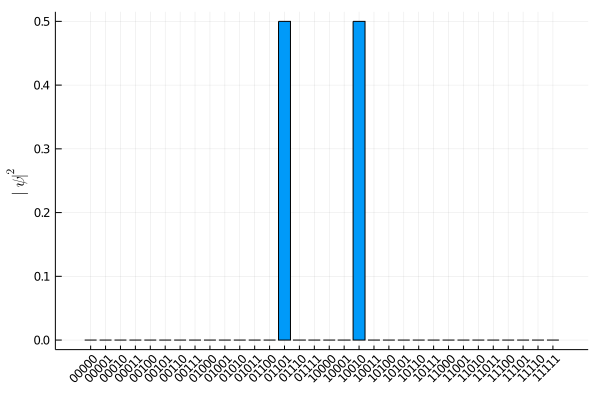

In [14]:
tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(ψ2), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false)

Note that there are actually two optimal solutions, $b^{\text{opt}} = 01101$ and $b^{\text{opt}} = 10010$ (since one can swap the role of $\color{blue}{S_0}$ and $\color{green}{S_1}$), which indeed occur with the highest probability.